In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
# # sales_data = pd.read_excel('C:/Users/michelj8/Downloads/Sales_Transactions_Dataset_Weekly.xlsx',sheet_name = 'Sheet1')
# sales_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/Sales_Transactions_Dataset_Weekly.xlsx', sheet_name = 'Sheet1')
# sales_data = sales_data.set_index('Product_Code')

m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Year')

In [124]:
m3_df = m3_df.query('Category == "MACRO       "')

In [131]:
def exp_smooth(Y,alpha):
    smooth = [Y[0]]
    for t in range(1, len(Y)):
        smooth.append( (1-alpha)*Y[t] + (alpha)* smooth[t-1])    
    return smooth

def objective(Y,alpha,penalty):
    data = pd.DataFrame({'Y':Y, 'est':exp_smooth(Y,alpha)})
    data['est'] = data['est'].shift(1)
    data = data.dropna()
    
    sum_squares = np.square(data['Y'] - data['est']).sum() + penalty*abs(alpha)
    return sum_squares

def minimal_alpha(Y, penalty, grid_size):
    alphas = np.linspace(0,1,grid_size)
    
    min_alpha = 0.0
    min_obj = np.square( np.diff( np.array(Y)) ).sum()
    
    for alpha in alphas:
        sum_squares = 0.0
        forecast = Y[0]
        
        for t in range(1, len(Y)):
            sum_squares = sum_squares + np.square(Y[t]-forecast)
            forecast = (1-alpha)*Y[t] + alpha*forecast
        
        obj = sum_squares + penalty*alpha
        
        if obj < min_obj:
            min_alpha = alpha
            min_obj = obj
            
    return min_alpha

# Alpha SES for all data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0996F238>]],
      dtype=object)

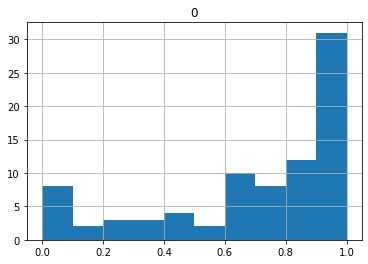

In [132]:
min_alphas = []

for index in m3_df.index:
# for index in range(0, 10):
    ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[index].dropna()
    ts = np.log(ts).diff(1).dropna().values
#     ts = np.log(ts).dropna().values
    min_alphas.append( minimal_alpha(ts,0.0, 50) )
    
pd.DataFrame(min_alphas).hist()

## Analysis for all series

In [133]:
test_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','opt_lambda','sse_ses','sse_lasso'])


for prod in m3_df.index:
    Y = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[prod].dropna()
    Y = np.log(Y).diff(1).dropna().values 
#     Y = np.log(Y).dropna().values 
    sample_size = len(Y)

    Y_train = Y[0:round(sample_size/2.5)]
    Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)]
    Y_test = Y[2*round(sample_size/2.5):]


    train_index = range(0,round(sample_size/2.5))
    validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
    test_index = range(2*round(sample_size/2.5),sample_size)


    penalty_list = np.linspace(0,.1,100)
    # penalty_list = np.linspace(0,400,50)

    cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
    cv_df['penalty'] = penalty_list
    cv_df = cv_df.set_index('penalty')

    for pen in penalty_list:
        train_alpha = minimal_alpha(Y_train,pen,200)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()

        val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        cv_df.loc[pen] = [train_alpha,val_sse,test_sse]

    cv_df = cv_df.reset_index()


    opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

    alpha_list = []
    oos_error_list = []
    for pen in [0.0, opt_lambda]:
        train_alpha = minimal_alpha(np.append(Y_train,Y_validate),pen, 200)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        alpha_list.append(train_alpha)
        oos_error_list.append(test_sse)

    
    test_df.loc[prod] = alpha_list +[opt_lambda] +oos_error_list

In [134]:
test_df

,alpha_ses,alpha_lasso,opt_lambda,sse_ses,sse_lasso
248,0.839196,0.839196,0.000000,0.002572,0.002572
249,0.708543,0.597990,0.003030,0.000774,0.000730
250,0.763819,0.763819,0.000000,0.003782,0.003782
251,0.618090,0.286432,0.002020,0.000850,0.000751
252,0.929648,0.000000,0.004040,0.001242,0.001180
...,...,...,...,...,...
326,0.894472,0.889447,0.004040,0.000668,0.000600
327,0.778894,0.763819,0.006061,0.011086,0.011197
328,0.984925,0.934673,0.046465,0.014764,0.011479
329,1.000000,1.000000,0.000000,0.008948,0.008948


In [161]:
minimal_alpha(Y,0.2,100)

0.0

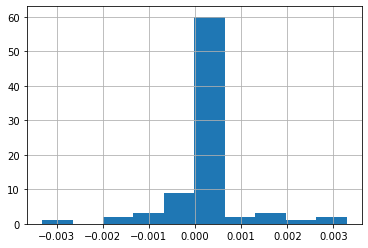

In [135]:
test_df['sse_delta'] = (test_df['sse_ses'] - test_df['sse_lasso'])
test_df['sse_delta'].hist()

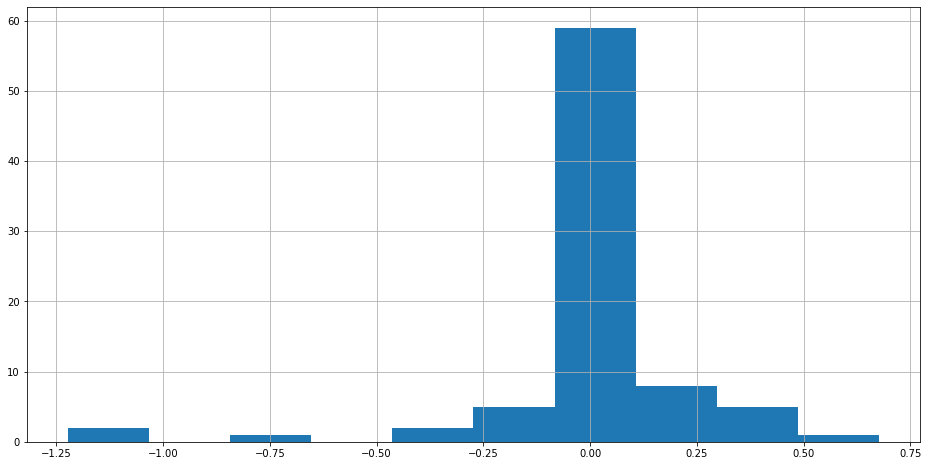

In [136]:
fig, ax = plt.subplots(figsize = (16,8))

(test_df['sse_delta']/test_df['sse_ses']).hist(ax = ax)

In [165]:
len(test_df.query('sse_delta < 0'))/len(test_df)

0.20481927710843373

In [166]:
len(test_df.query('sse_delta > 0'))/len(test_df)

0.3493975903614458

In [167]:
len(test_df.query('sse_delta == 0'))/len(test_df)

0.4457831325301205

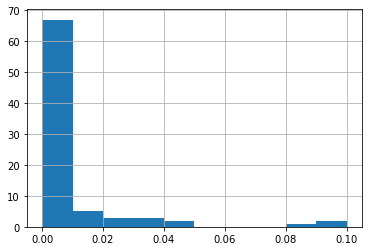

In [140]:
test_df['opt_lambda'].hist()

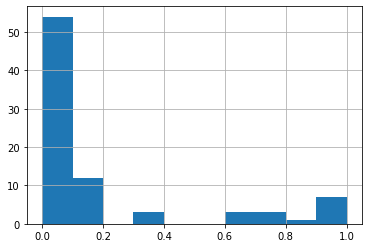

In [141]:
(test_df['alpha_ses'] - test_df['alpha_lasso']).hist()

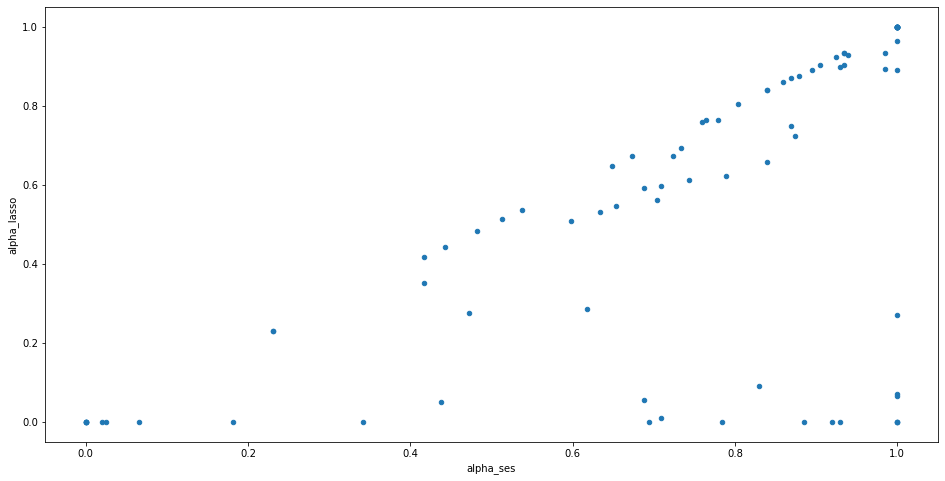

In [142]:
fig, ax = plt.subplots(figsize = (16,8))

test_df.plot.scatter(x='alpha_ses',y='alpha_lasso', ax = ax)

[Text(0, 0, '.4'),
 Text(0, 0, '.5'),
 Text(0, 0, '.6'),
 Text(0, 0, '.7'),
 Text(0, 0, '.8'),
 Text(0, 0, '.9'),
 Text(0, 0, '1')]

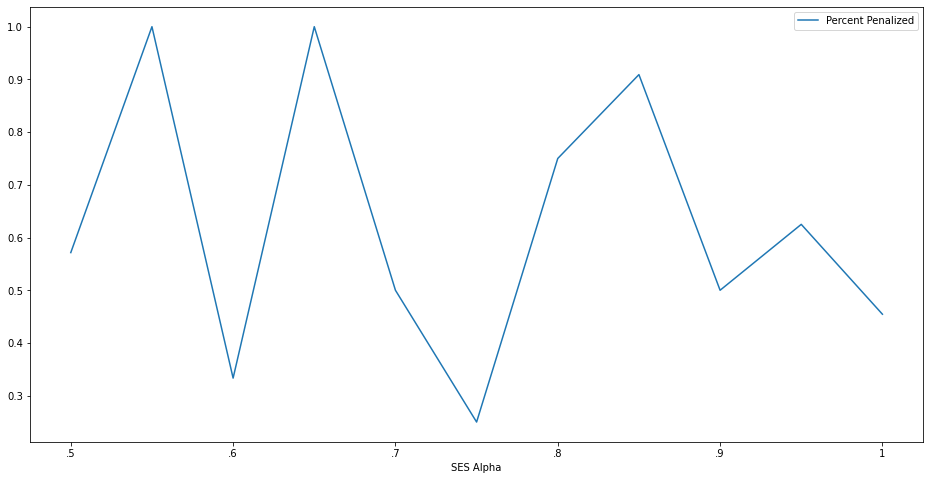

In [143]:
test_df['ses_bucket']=  test_df['alpha_ses'].apply(lambda s: round(10*s))
test_df['penalized'] = 1*(test_df['opt_lambda']>0)

fig, ax = plt.subplots(figsize = (16,8))
test_df[['ses_bucket','penalized']].groupby('ses_bucket').mean().plot(ax = ax)

ax.legend(['Percent Penalized'])
ax.set_xlabel('SES Alpha')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['.4','.5','.6','.7','.8','.9','1']
ax.set_xticklabels(labels)

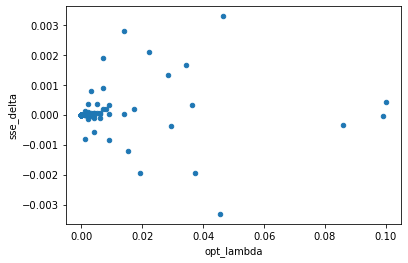

In [144]:
test_df.plot.scatter(x='opt_lambda',y='sse_delta')

In [162]:
len(m3_df)

83

# Multistep forecasts

In [149]:
multi_step_df = pd.DataFrame(columns = range(1,7))

for prod in m3_df.index:
    Y = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[prod].dropna()
    Y = np.log(Y).diff(1).dropna().values 
    sample_size = len(Y)
    test_index = range(2*round(sample_size/2.5),sample_size)


    alpha_ses = test_df.loc[prod,'alpha_ses']
    alpha_lasso = test_df.loc[prod,'alpha_lasso']
    
    for h in range(1,7):
        ses_exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha_ses)})
        ses_exp_df['exp'] = ses_exp_df['exp'].shift(h) 
        ses_exp_df = ses_exp_df.reset_index() 
        ses_error = np.square(ses_exp_df.loc[test_index]['Y'] - ses_exp_df.loc[test_index]['exp']).sum()
        
        lasso_exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha_lasso)})
        lasso_exp_df['exp'] = lasso_exp_df['exp'].shift(h) 
        lasso_exp_df= lasso_exp_df.reset_index()
        lasso_error = np.square(lasso_exp_df.loc[test_index]['Y'] - lasso_exp_df.loc[test_index]['exp']).sum()
        
        multi_step_df.loc[prod,h] =  (ses_error - lasso_error)

In [150]:
for h in range(1,7):
    print(h)
    print(sum(1*(multi_step_df[h] > 0))/len(multi_step_df), sum(1*(multi_step_df[h] >= 0))/len(multi_step_df))
    print()

1
0.3493975903614458 0.7951807228915663

2
0.14457831325301204 0.5903614457831325

3
0.12048192771084337 0.5662650602409639

4
0.18072289156626506 0.6265060240963856

5
0.21686746987951808 0.6626506024096386

6
0.18072289156626506 0.6265060240963856

